In [44]:
import numpy as np
import qutip
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import matplotlib
import colour ### https://www.colour-science.org/installation-guide/

im = 0+1j

In [45]:
def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
#     R *= 255
#     G *= 255
#     B *= 255
    return (R, G, B)

## A 2x2 matrix which represents a general birefringent material

In [46]:
def GenWP(theta, eta):
    return np.exp(-im*eta/2)*np.array(
        [[np.cos(theta)**2+np.exp(im*eta)*np.sin(theta)**2 , (1-np.exp(im*eta))*np.cos(theta)*np.sin(theta)],
         [(1-np.exp(im*eta))*np.cos(theta)*np.sin(theta),np.sin(theta)**2+np.exp(im*eta)*np.cos(theta)**2]])

## The orientation of the inital polarized light

In [47]:
iTheta = 0 * (2*np.pi) # Angle in radians relative to horizontal

IP = np.array([np.cos(iTheta)+0j,
               np.sin(iTheta)+0j])
IP /= np.linalg.norm(IP)

## The orientation of the final polarized light

In [48]:
fTheta = 0.25 * (2*np.pi) # Angle in radians relative to horizontal

FP = np.array([np.cos(fTheta)+0j,
               np.sin(fTheta)+0j])
FP /= np.linalg.norm(FP)

### The final polariztion of light of a specific color will be displayed on a bloch sphere. Transparency is defined by how much will make it through the final projection. Read comments to add additional gates.

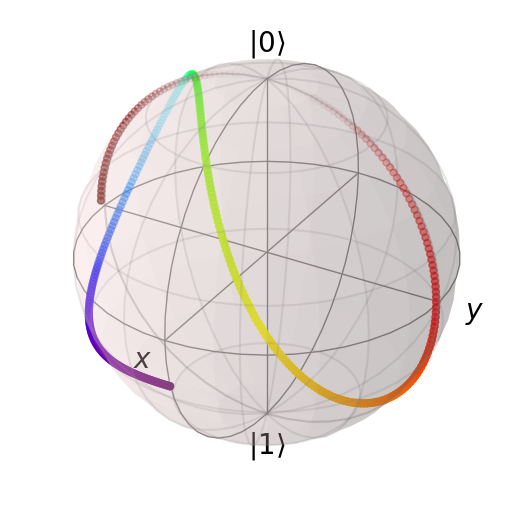

<Figure size 640x480 with 0 Axes>

In [69]:
plt.figure()

b = qutip.Bloch()
# b.view = [180,0]
b.make_sphere()
b.point_color = []
b.point_marker = [b.point_marker[0]]
b.point_size = [b.point_size[0]]

n = 371
wls = np.linspace(380,750,n)

eta = 2*np.pi/700  # Birefringent material will have a wavelength that is unaffected by orientation. 
                   # That wavelength is what is in the divisor.

pts = []

Is = []
As = []

for w in wls:
    
    rgb = wavelength_to_rgb(w)
    
    v = np.matmul(GenWP(np.pi*0.25, eta*w), IP) # 1st, theta, gives orientation, 2nd, eta, is an arguement of width
    v = np.matmul(GenWP(np.pi*.25, eta*w), v) # Successive gates are applied such as is shown in this comment.
    v = np.matmul(GenWP(np.pi*-.625, eta*w), v) # Successive gates are applied such as is shown in this comment.
    v = np.matmul(GenWP(np.pi*.125, eta*w), v) # Successive gates are applied such as is shown in this comment.

    I = np.sum(FP*v)
    I *= np.conj(I)
    I = np.real(I)
    
    Is.append(I)
    
    if (380 <= w <= 750):
        As.append(I)
    else:
        As.append(0.0)
    
#     rgba = (rgba[0],rgba[1],rgba[2],0)
    
    b.point_color.append(rgb)

    u = v[1]/v[0]

    Px = 2*np.real(u)/(1+np.linalg.norm(u)**2)
    Py = 2*np.imag(u)/(1+np.linalg.norm(u)**2)
    Pz = (1-np.linalg.norm(u)**2)/(1+np.linalg.norm(u)**2)

    pts.append([Px,Py,Pz])

# b.add_points([[p[0] for p in pts], [p[1] for p in pts], [p[2] for p in pts]], "m", Is)
for i in range(n):
    b.add_points(pts[i], "s", alpha=As[i])
    
Is = np.array(Is)

b.show();

## The spectrum of visible light

### Use coulour package to display colour that should be seen.

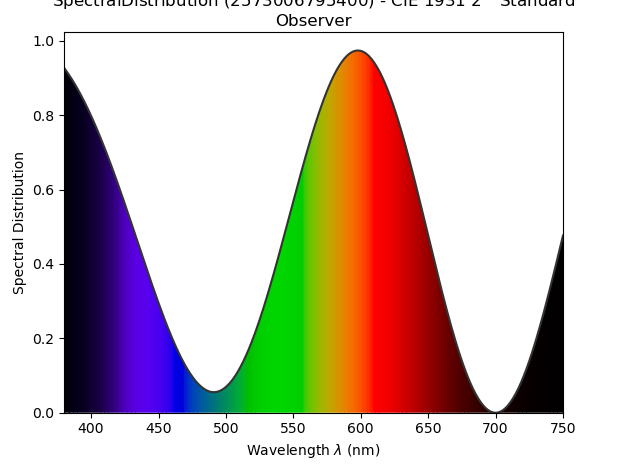

In [70]:
sd = colour.SpectralDistribution(Is, wls)
colour.plotting.plot_single_sd(sd);

C:\ProgramData\Anaconda3\lib\site-packages\colour\utilities\verbose.py:237: ColourUsageWarning: The "Automatic Colour Conversion Graph" is a beta feature, be mindful of this when using it. Please report any unexpected behaviour and do not hesitate to ask any questions should they arise.
This warning can be disabled with the "colour.utilities.suppress_warnings" context manager as follows:
with colour.utilities.suppress_warnings(colour_usage_warnings=True): 
    convert(*args, **kwargs)
  warn(*args, **kwargs)


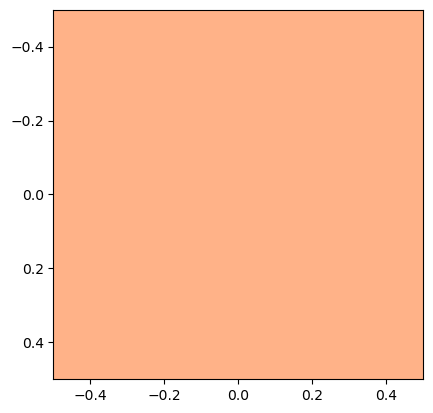

In [71]:
plt.imshow([[colour.convert(sd, 'Spectral Distribution', 'sRGB')]]);